# **1st Training**

Outline
1. Import Modules & Set Up Device
2. Load Images & Create Labels
3. Preprocessing and Data Augmentation
4. Custom Dataset Class & Data Loader
5. Create CNN Model
6. Model Training
7. Evaluation

**#1 Import Modules and Set Up Device**

In [ ]:
# Import Module and Libraries

import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

**#2 Load Images & Create Labels**

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths
train_dir = os.path.abspath("datasets/Brain-Tumor-Classification-2D")

# Define labels
tumor_labels = ["Astrocytoma"]
# tumor_labels = ["Astrocytoma", "Glioblastoma", "Gliomas", "Meningioma", "Neurocytoma"]

IMG_SIZE = (256, 256)

# Initialize lists
X, y = [], []

# Iterate over dataset directories
for label in tumor_labels:
    label_path = os.path.abspath(os.path.join(train_dir, label))
    print(f"label_path: {label_path}")

    if not os.path.isdir(label_path):
        print(f"Skipping non-folder: {label_path}")
        continue

    # List files in the label directory
    folder_contents = os.listdir(label_path)

    for filename in sorted(folder_contents):
        img_path = os.path.join(label_path, filename)

        if not os.path.isfile(img_path):                    # Skip non-image files
            print(f"Skipping non-image file: {img_path}")   # Debugging
            continue

        # Generate two possible mask filenames: one with '_mask' and one with 'mask_'
        mask_filename_1 = filename.replace(".tif", "_mask.tif")    # Using '_mask' naming convention
        mask_filename_2 = filename.replace(".tif", "mask_.tif")    # Using 'mask_' naming convention

        mask_path_1 = os.path.join(label_path, mask_filename_1)
        mask_path_2 = os.path.join(label_path, mask_filename_2)

        # Check if either mask file exists
        mask_path = None
        if os.path.exists(mask_path_1):
            mask_path = mask_path_1
        elif os.path.exists(mask_path_2):
            mask_path = mask_path_2

        if mask_path:
            try:
                # Load and preprocess image in grayscale
                # img = load_img(img_path, target_size=IMG_SIZE, color_mode="rgb")
                img = load_img(img_path, target_size=IMG_SIZE, color_mode="grayscale")
                img = img_to_array(img) / 255.0  # Normalize image
                # img = img.squeeze()  # Remove redundant dimension

                # Load grayscale mask
                mask_img = load_img(mask_path, target_size=IMG_SIZE, color_mode="grayscale")
                mask_img = img_to_array(mask_img).squeeze() / 255.0  # Normalize mask

                # Append to dataset
                X.append(img)
                y.append(mask_img)  # Target remains tumor mask

            except Exception as e:
                print(f"Error loading {img_path}: {e}")

# Convert to numpy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

print(f"Dataset Loaded (X, y): {X.shape}, {y.shape}")  # (num_samples, 256, 256, 3) and (num_samples, 256, 256)


label_path: c:\Users\ilhag\Desktop\CV-MiniProject\Project#1\datasets\Brain-Tumor-Classification-2D\Astrocytoma
Dataset Loaded (X, y): (529, 256, 256, 1), (529, 256, 256)


[ 27 129 300]


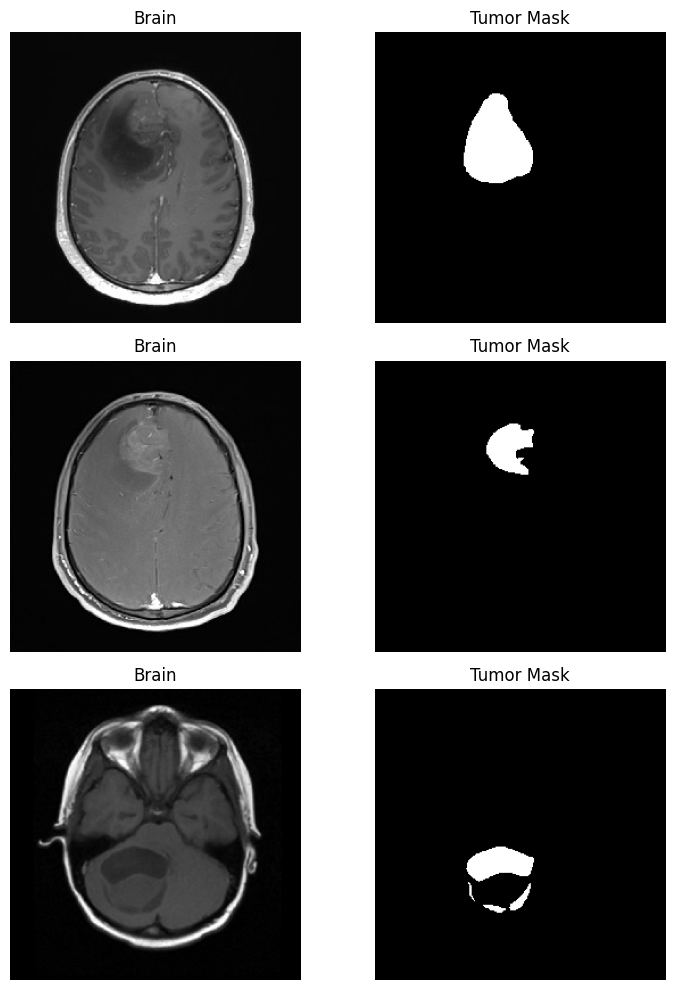

In [3]:
# Display some images and their labels
import numpy as np
import matplotlib.pyplot as plt


num_samples = min(3, len(X))
indices = np.random.choice(len(X), num_samples, replace=False)

print(indices)

# Plot images
fig, axes = plt.subplots(num_samples, 2, figsize=(8, 10))

for i, idx in enumerate(indices):
    brain = X[idx]  # Original grayscale brain scan
    label_idx = y[idx]  # Numeric label

    # Display original brain scan
    axes[i, 0].imshow(brain.squeeze(), cmap="gray")
    axes[i, 0].set_title("Brain")
    axes[i, 0].axis("off")

    # Display tumor label as text (if you need a mask, this will need to be adjusted)
    axes[i, 1].imshow(label_idx.squeeze(), cmap="gray")
    axes[i, 1].set_title("Tumor Mask")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

**#3 Data Splitting**

In [5]:
import numpy as np

# Validate before conversion
if len(X) == 0 or len(y) == 0:
    raise ValueError("No valid image-mask pairs found. Check dataset structure and naming conventions.")

# Verify shapes
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (529, 256, 256, 1)
y shape: (529, 256, 256)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train)} images, Validation set: {len(X_val)} images")


Training set: 423 images, Validation set: 106 images


#4 Create CNN Model

In [1]:
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
# from tensorflow.keras.models import Model

# def conv_block(inputs, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(inputs)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     return x

# def encoder_block(inputs, num_filters):
#     x = conv_block(inputs, num_filters)
#     p = MaxPool2D((2, 2))(x)
#     return x, p

# def decoder_block(inputs, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x

# def build_unet(input_size=(256, 256, 1)):
#     inputs = Input(input_size)

#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

#     # print(s1.shape, s2.shape, s3.shape, s4.shape)
#     # print(p1.shape, p2.shape, p3.shape, p4.shape)

#     b1 = conv_block(p4, 1024)

#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

#     model = Model(inputs, outputs, name="UNET-2.0")
#     return model

# model = build_unet()
# model.summary()

In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = UpSampling2D(size=(2, 2))(inputs)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    # Bottleneck
    b = conv_block(p4, 1024)
    
    # Decoder
    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)
    
    model = Model(inputs, outputs, name="UNET-1.0")
    return model

# Create the U-Net model
model = build_unet()
model.summary()

Model: "UNET-1.0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# import tensorflow.keras.backend as K
# import tensorflow as tf

# def dice_loss(y_true, y_pred):
#     smooth = 1.0  # To avoid division by zero
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# def conv_block(inputs, num_filters, dropout_rate=0.2):
#     x = Conv2D(num_filters, 3, padding="same")(inputs)
#     x = BatchNormalization()(x)
#     x = Activation(tf.keras.layers.LeakyReLU(alpha=0.1))(x)

#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)
#     x = Activation(tf.keras.layers.LeakyReLU(alpha=0.1))(x)

#     if dropout_rate > 0:
#         x = Dropout(dropout_rate)(x)  # Dropout to prevent overfitting

#     return x

# def encoder_block(inputs, num_filters, dropout_rate=0.2):
#     x = conv_block(inputs, num_filters, dropout_rate)
#     p = MaxPool2D((2, 2))(x)
#     return x, p

# def decoder_block(inputs, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters, dropout_rate=0.0)  # No dropout in decoder
#     return x

# def build_unet(input_size=(256, 256, 1)):
#     inputs = Input(input_size)

#     # Encoder
#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512, dropout_rate=0.3)  # Increased dropout for deeper layers

#     # Bottleneck
#     b1 = conv_block(p4, 1024, dropout_rate=0.4)  # Highest dropout at bottleneck

#     # Decoder
#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

#     model = Model(inputs, outputs, name="tumorsegm-3")
    
#     return model

# # Create model
# model = build_unet(input_size=(256, 256, 1))
# model.summary()


#5 Model Training

In [10]:
import numpy as np

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

print("Unique values in y_train:", np.unique(y_train))

print(f' ')
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())
print(np.isnan(X_val).sum(), np.isnan(y_val).sum())

X_train shape: (423, 256, 256, 1)
y_train shape: (423, 256, 256)
X_val shape: (106, 256, 256, 1)
y_val shape: (106, 256, 256)
Unique values in y_train: [0. 1.]
 
0 0
0 0


In [11]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)

    numerator = 2 * tf.reduce_sum(y_true * y_pred) + smooth
    denominator = tf.reduce_sum(y_true + y_pred) + smooth

    return 1 - numerator / denominator

# optimizer = Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Lower learning rate
# model.compile(optimizer=optimizer, loss=dice_loss, metrics=['accuracy'])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8)


# Save the trained model
model.save('tumorsegm-2.50.h5')

Epoch 1/50
12/53 ━━━━━━━━━━━━━━━━━━━━ 5:22 8s/step - accuracy: 0.9197 - loss: 0.4268

#6 Evaluation

In [ ]:
# loss, accuracy, dice_coefficient = model.evaluate(X_val, y_val)
# print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}, Dice Coefficient: {dice_coefficient}")

loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.9875 - loss: 0.0971
Validation Loss: 0.09684298187494278, Validation Accuracy: 0.9876585006713867


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


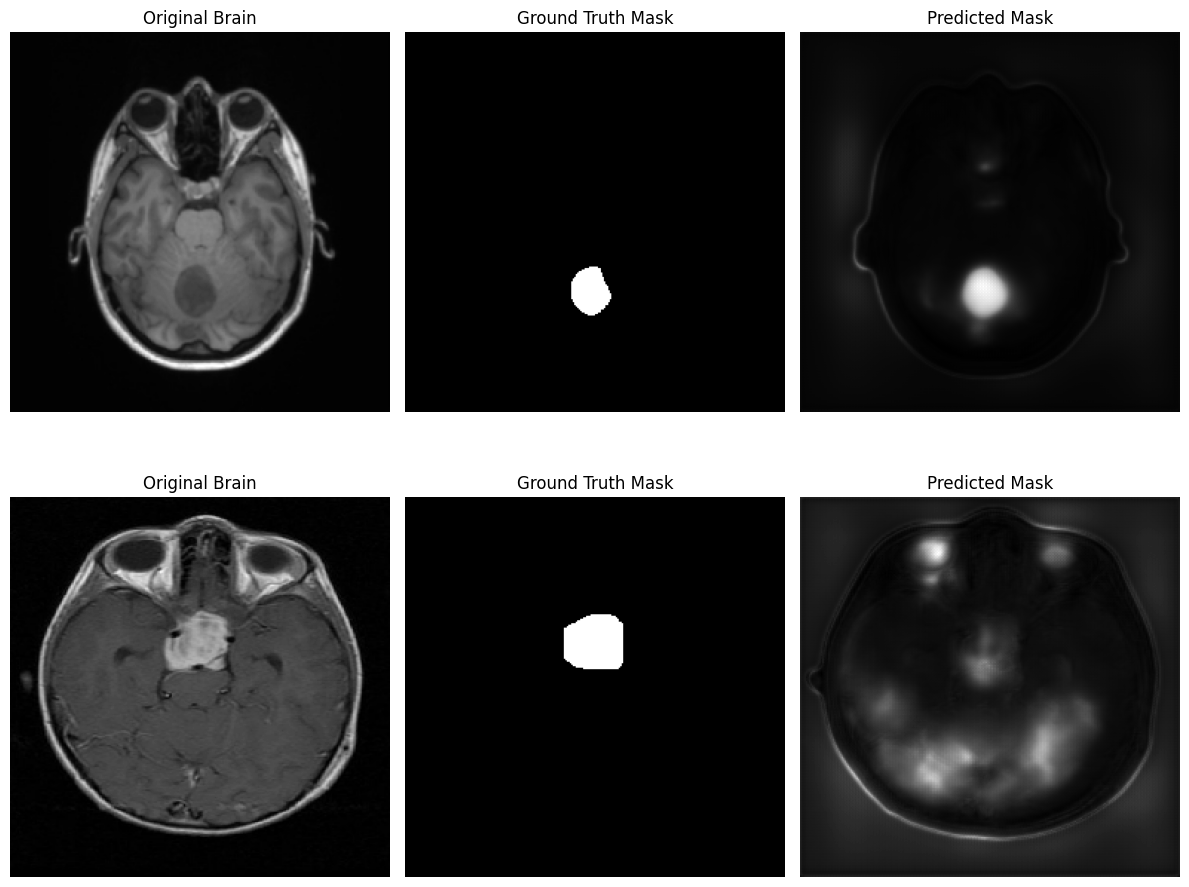

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_samples = min(2, len(X_val))  # Align with X_val
indices = np.random.choice(len(X_val), num_samples, replace=False)

fig, axes = plt.subplots(num_samples, 3, figsize=(12, 10))

for i, idx in enumerate(indices):
    brain = X_val[idx]        # Original image
    tumor = y_val[idx]        # Ground truth tumor mask

    # Predict the segmentation mask
    pred_mask = model.predict(np.expand_dims(brain, axis=0))  # Add batch dimension
    pred_mask = pred_mask.squeeze()                           # Remove batch dimension

    # Threshold to get binary mask
    # pred_mask = (pred_mask > 0.3).astype(np.uint8)

    # Display original brain scan
    axes[i, 0].imshow(brain, cmap="gray")
    axes[i, 0].set_title("Original Brain")
    axes[i, 0].axis("off")

    # Display ground truth tumor mask
    axes[i, 1].imshow(tumor, cmap="gray")
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    # Display predicted mask
    axes[i, 2].imshow(pred_mask, cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()